In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize, Bounds
from scipy.stats import describe, iqr, norm
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

# Gaussian Kernel Density Estimation

Kernel density estimator (KDE) function:

$$
\hat{f}(x \, | \, h) = \frac{1}{nh} \sum^{n}_{i=1} K \left( \frac{x - x_i}{h} \right)
$$

Gaussian kernel:

$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2} u^2 \right)
$$

KDE function now becomes:

$$
\hat{f}(x \, | \, h) = \frac{1}{n} \sum^{n}_{i=1} \frac{1}{h \sqrt{2\pi}} \exp \left(-\frac{1}{2} \left(\frac{x - x_i}{h} \right)^2 \right)
$$

where the inside of the sum is identical to $\mathcal{N}(\mu = x_i, \, \sigma = h)$.

Bandwidth $h$ is computed using leave-one-out cross validation:

$$
\min_{\hat{h}} \left[ \int{{\hat{f}(x \, | \, h)}^2 \, dx} - \frac{2}{n} \sum^{n}_{i=1} \hat{f}_{-i} (x_i \, | \, h) \right]
$$

References: 

David W. Scott, Stephan R. Sain,
9 - Multidimensional Density Estimation,
Editor(s): C.R. Rao, E.J. Wegman, J.L. Solka,
Handbook of Statistics,
Elsevier,
Volume 24,
2005,
Pages 229-261,
ISSN 0169-7161,
ISBN 9780444511416,
https://doi.org/10.1016/S0169-7161(04)24009-3.
(https://www.sciencedirect.com/science/article/pii/S0169716104240093)

## Derivation of the CDF

Let $\phi_{i}(x | h) = \phi(x | \mu = x_{i}, \sigma = h) $ be the PDF of the normal distribution, and let $\Phi_{i}(x | h) = \Phi(x | \mu = x_{i}, \sigma = h) = \int_{-\infty}^{x} \phi_{i}(u | h) du$ be the CDF of the normal distribution.

The CDF $\hat{F}(x | h)$ of the kernel density estimate is derived as follows:

$$ \hat{F}(x | h) = \int_{-\infty}^{x} \hat{f}(u | h) \,du $$

$$ \hat{F}(x | h) = \int_{-\infty}^{x} \left[ \frac{1}{n} \sum_{i=1}^{n} \phi_{i}(u | h) \right] \,du $$

$$ \hat{F}(x | h) = \frac{1}{n} \sum_{i=1}^{n} \int_{-\infty}^{x} \phi_{i}(u | h) \,du $$

$$ \hat{F}(x | h) = \frac{1}{n} \sum_{i=1}^{n} \Phi_{i}(x | h) $$

In [5]:
class KDE_1D:
    def __init__(self, data):
        self.data = data
    
    def pdf(self, x, h):
        # probability density function of kernel density estimate
        return np.sum([norm.pdf(x, loc=x_i, scale=h) for x_i in self.data]) / len(self.data)
    
    def cdf(self, x, h):
        # cumulative distribution function of kernel density estimate
        # returns nonexceedance probability P(X <= x)
        return np.sum([norm.cdf(x, loc=x_i, scale=h) for x_i in self.data]) / len(self.data)
    
    def ucv(self, h):
        # unbiased cross-validation, see Scott & Sain, 2005 (pg. 236)
        loo = LeaveOneOut()
        er_sq = quad(lambda x: self.pdf(x, h) ** 2, -np.inf, np.inf)[0]
        er_lo = (2 / len(self.data)) * np.sum([
            np.sum([norm.pdf(self.data[test], loc=x_i, scale=h) for x_i in self.data[train]]) / len(train)
            for train, test in tqdm(
                loo.split(self.data),
                desc='Computing LOO component',
                total=len(self.data)
            )
        ])
        return er_sq - er_lo
    
    def find_bandwidth(self):
        # find optimal bandwidth by minimizing error
        # start with suboptimal bandwidth
        h0 = [0.9 * np.minimum(np.sqrt(describe(self.data).variance), iqr(self.data) / 1.34) * np.power(len(self.data), -1 / 5)]
        # bandwidth constrained to be positive
        bounds = Bounds([1e-8], [np.inf])
        return minimize(self.ucv, h0, method='trust-constr', bounds=bounds).x[0]

In [6]:
data = np.random.normal(5, 1.5, 100)
k = KDE_1D(data)
h_best = k.find_bandwidth()
h_best

Computing LOO component: 100%|██████████| 100/100 [00:00<00:00, 151.24it/s]


0.8353284227588791

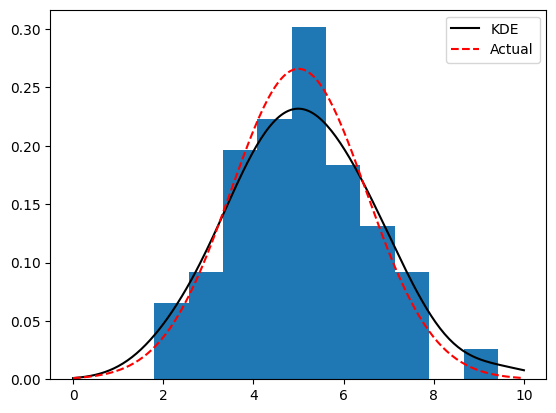

In [7]:
x = np.linspace(0, 10, 200)
y = [k.pdf(xn, h_best) for xn in x]
y0 = norm.pdf(x, loc=5, scale=1.5)
plt.hist(data, density=True)
plt.plot(x, y, c='black', label='KDE')
plt.plot(x, y0, 'r--', label='Actual')
plt.legend();